In [5]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import h5py
import anndata as ad
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

### Dataset Description
This dataset contain two types of data for a combinatorial library containing approximately 14,000 compounds that we call ZEL024. This library was designed with the goal of inhibiting the RNA methyltransferase, METTL3, which has gained considerable attention as a target to treat cancer and inflammatory diseases. 

Controls in this library include the compounds STC15 and STM2457, known inhibitors of METTL3 developed by Storm Therapeutics. Phenotypic imaging data was collected from H1650 cells and transcriptome data was collected from HEK293T cells. Each data type was collected from 2 different devices.  

Imaging data is provided as 1 "plain" HDF5 file per array, and each HDF5 file is accompanied by 2 CSV files which describe the first 2 dimensions of the "images" dataset in the HDF5 file; the last two dimensions are image height and image width. Transcriptome counts data is provided in an AnnData-format HDF5 file, and the metadata is stored in the .obs DataFrame. The source device for the transcriptome data is available in the device_id column of the .obs DataFrame. 

In total, there are approximately 55,300 transcriptome observations and 26,500 phenotype observations.

### Metadata Description
All observations are described by 5 columns of metadata: control_rx_id, bb1_id, bb2_id, bb3_id, bb4_id, and censored. The censored column indicates that the chemical identity information for that well has been hidden, and all the values for the other columns ending in _id should be -1. About 20% of the data has been censored. For the remaining 80% of the data, a combination of the columns ending in _id can be used to look up the associated chemical perturbation in the smiles.csv file. For the imaging data, these columns can be found in the _dim_0_metadata.csv files, along with a physical_well_id columns which identifies the source of the imaging data. Some wells are imaged more than once during data collection. For those wells, both sets of images are included and share a value in the physical_well_id column.

### Interpretive Data

Each device's imaging data includes 2 extra files, {device}.segmentations.h5 and {device}.beadlocations.csv which contain some cell segmentation data and the locations of beads within the images in {device}.h5, respectively.

The segmentations are present in their HDF5 as an "images" dataset, but with only 3 dimensions (n_obs x H x W). A positional value of zero indicates that the pixel was not detected as a cell, and all pixels with each unique non-zero positive integer correspond to one cell; integer values are unique only within a single slice along the first dimension of data. Despite some weak spots, these maps have served us well for QC purposes.

Bead detections in the associated CSV have 4 columns: hdf5_dim_0_index, cx, cy, and radius.

hdf5_dim_0_index maps to the first dimension of the images/segmentations HDF5s
cy maps to the second-to-last dimension of the images/segmentations HDF5s
cx maps to the last dimension of the images/segmentations HDF5s
radius is the radius of a (rough) circle centered at cy, cx

### Notes

There are certainly artifacts present which we'd prefer to avoid (some we're aware of include images being out-of-focus or perturbation delivery beads moving from their expected locations) and we look forward to sharing improved datasets in the future. Nonetheless, we've found some interesting patterns in these data and we'd be absolutely delighted to learn of any interesting patterns you can find (whether artifacts or biological patterns)!

Microscopy data

In [11]:
file_path = './zel024/microscopy/ZS13.h5'  # replace with your file path
with h5py.File(file_path, 'r') as file:
    # Print all root level object names (aka keys) 
    print("Keys in the file:")
    for key in file.keys():
        print(key)

    dataset = file['images'][:]

Keys in the file:
images


In [12]:
dataset.shape

(10661, 5, 340, 340)

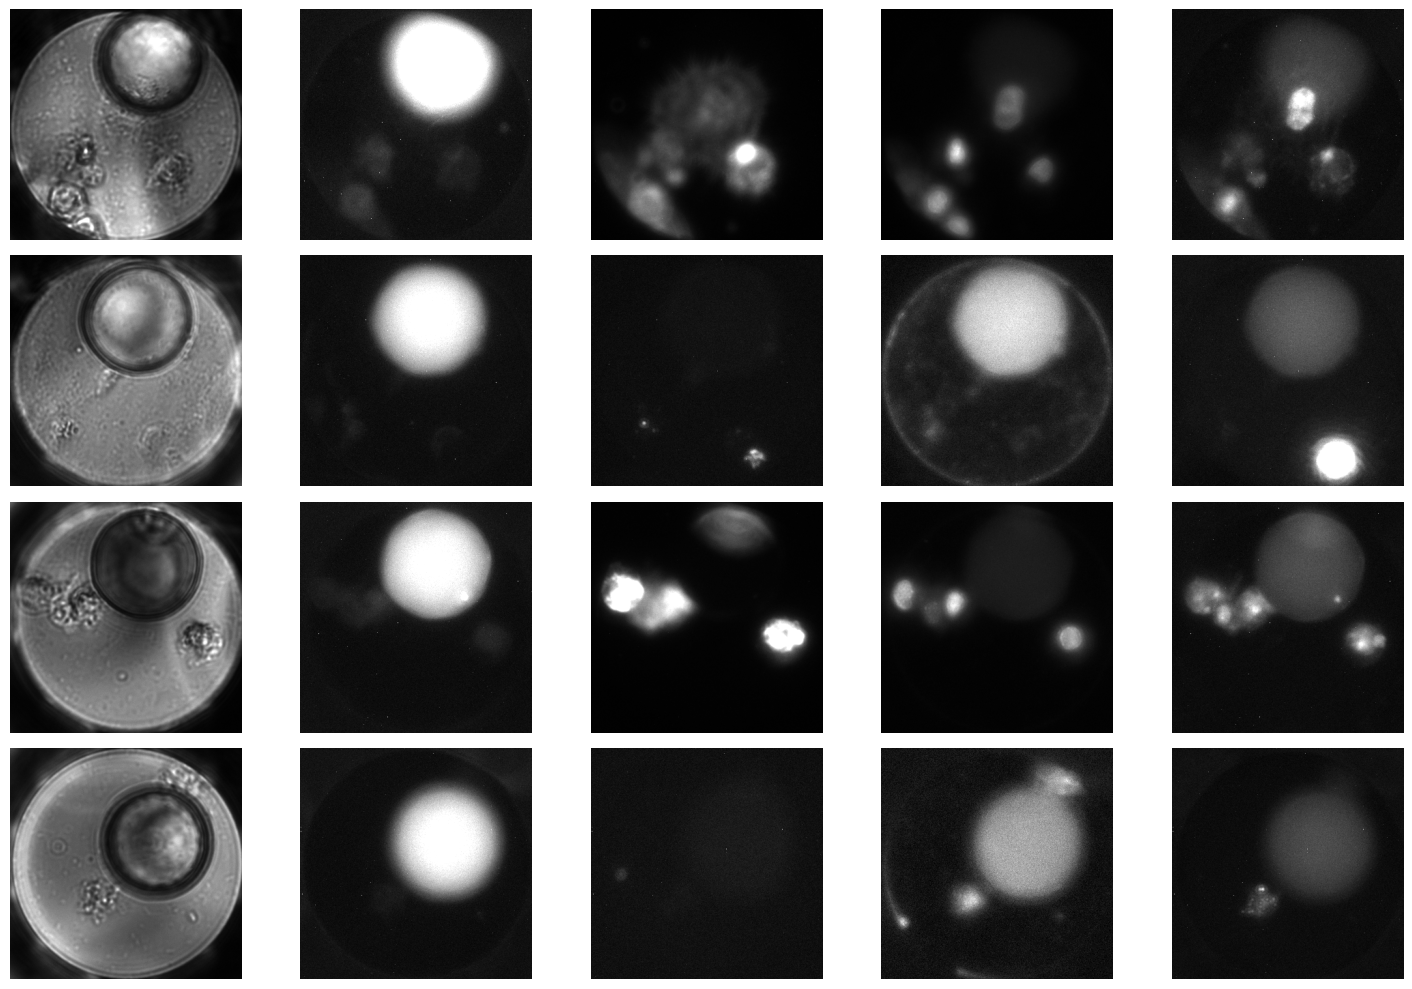

In [13]:
# Number of images to display
num_images_to_display = 4

# Randomly select indices
random_indices = np.random.choice(dataset.shape[0], num_images_to_display, replace=False)

# Create a figure for displaying the images
fig, axs = plt.subplots(num_images_to_display, 5, figsize=(15, 10))  # 4 rows, 5 columns

for i, idx in enumerate(random_indices):
    for j in range(5):  # Loop through the 5 channels
        axs[i, j].imshow(dataset[idx, j], cmap='gray')  # Assuming grayscale; use cmap=None for RGB
        axs[i, j].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [14]:
# dim_0_ metadata
dim_0 = pd.read_csv('./zel024/microscopy/ZS25_dim_0_metadata.csv')
dim_1 = pd.read_csv('./zel024/microscopy/ZS25_dim_1_metadata.csv')

In [15]:
dim_0

,hdf5_dim_0_index,physical_well_id,control_rx_id,bb1_id,bb2_id,bb3_id,bb4_id,censored
0,0,22,-1,269,195,1,1413,False
1,1,63,-1,-1,-1,-1,-1,True
2,2,81,-1,270,195,2,1389,False
3,3,113,-1,-1,-1,-1,-1,True
4,4,182,-1,215,352,2,406,False
...,...,...,...,...,...,...,...,...
21905,21905,49274,-1,-1,-1,-1,-1,True
21906,21906,49278,1,-1,-1,-1,-1,False
21907,21907,49278,1,-1,-1,-1,-1,False
21908,21908,49282,-1,-1,-1,-1,-1,True


In [16]:
dim_1

,hdf5_dim_1_index,description
0,0,BRIGHTFIELD
1,1,phalloidin
2,2,DAPI
3,3,anti-CDKN1A immunofluorescence


SMILES

In [17]:
smiles_data = pd.read_csv("./zel024/smiles.csv")
print(smiles_data.shape)
smiles_data.head()

(14121, 6)


,control_rx_id,bb1_id,bb2_id,bb3_id,bb4_id,SMILES
0,1,-1,-1,-1,-1,O=C1C=C(C(NCC2=CC3=C(C=C(CNCC4CCC4)N3)C=C2)=O)...
1,2,-1,-1,-1,-1,O=C(NCC1=C[N]2C=C(CNCC3CCCCC3)C=CC2=N1)C4=CC(=...
2,3,-1,-1,-1,-1,CC1CCN(Cc2nc(C(NC(CC3)CCN3c3c(cc[n]4C)c4nc(Cl)...
3,4,-1,-1,-1,-1,CC1CCN(Cc2nc(C(NC(CC3)CCN3c3c(cc[n]4S(c5ccc(C)...
4,5,-1,-1,-1,-1,CC1CCN(Cc2nc(C(NC(CC3)CCN3c3c(cc[n]4S(c5ccccc5...


RNAseq Data

In [18]:
rna_data = ad.read_h5ad("./zel024/rnaseq/4073_4074.h5ad")
rna_data.obs

,device_id,control_rx_id,bb1_id,bb2_id,bb3_id,bb4_id,censored
0,4073,-1,-1,-1,-1,-1,True
1,4073,-1,207,418,1,1943,False
2,4073,-1,213,123,2,1943,False
3,4073,-1,202,422,2,1943,False
4,4073,-1,201,422,1,1943,False
...,...,...,...,...,...,...,...
55291,4074,-1,205,352,1,1559,False
55292,4074,-1,213,422,1,1559,False
55293,4074,-1,222,123,1,1559,False
55294,4074,-1,205,417,1,1559,False


In [20]:
rna_data.obs.device_id.value_counts(), rna_data.obs.censored.value_counts(normalize=True)

(4073    29838
 4074    25458
 Name: device_id, dtype: int64,
 False    0.800004
 True     0.199996
 Name: censored, dtype: float64)

In [32]:
rna_data.obs.control_rx_id.value_counts()

-1     50482
 1       682
 8       565
 2       472
 3       444
 7       428
 9       395
 11      379
 4       378
 5       369
 6       357
 10      345
Name: control_rx_id, dtype: int64

In [21]:
rna_data.var # gene ids

""
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3
...
AC141272.1
AC023491.2
AC007325.1
AC007325.4


In [24]:
gex = rna_data.X
print(gex.shape)

(55296, 36601)


In [25]:
gex_df = pd.DataFrame(gex.toarray(), index=rna_data.obs.index, columns=rna_data.var.index)
print(gex_df.shape)
gex_df.head()

(55296, 36601)


,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


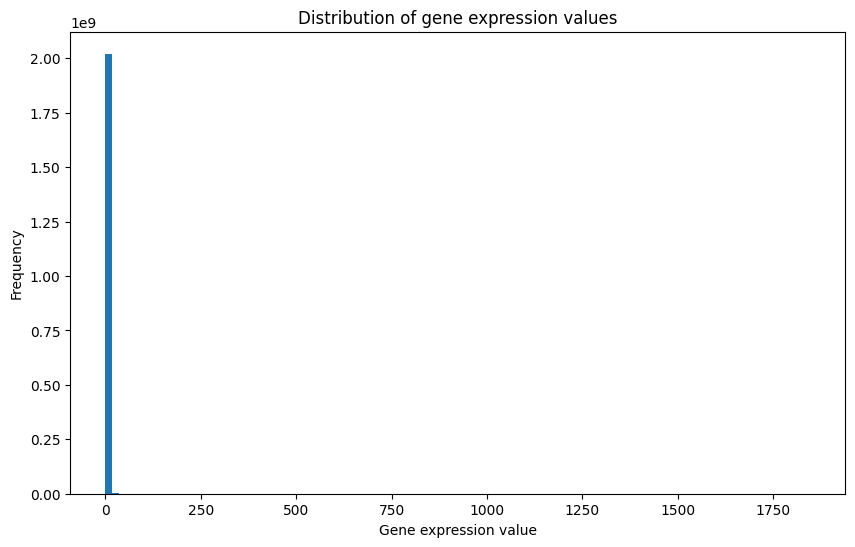

In [28]:
# plot distribution of gene expression values
plt.figure(figsize=(10, 6))
plt.hist(gex_df.values.flatten(), bins=100)
plt.xlabel('Gene expression value')
plt.ylabel('Frequency')
plt.title('Distribution of gene expression values')
plt.show()

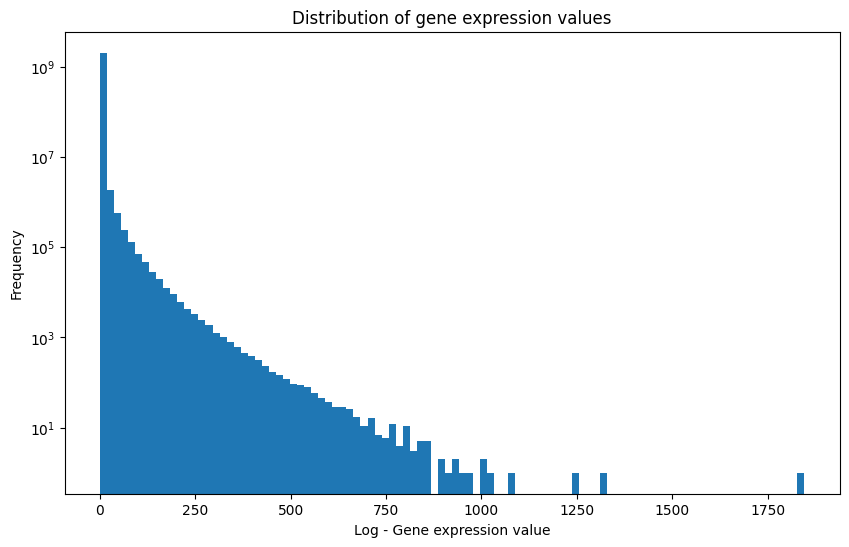

In [31]:
# take log of values
plt.figure(figsize=(10, 6))
plt.hist(gex_df.values.flatten(), bins=100, log=True)
plt.xlabel('Log - Gene expression value')
plt.ylabel('Frequency')
plt.title('Distribution of gene expression values')
plt.show()

Text(0.5, 1.0, 'Distribution of mean gene expression values')

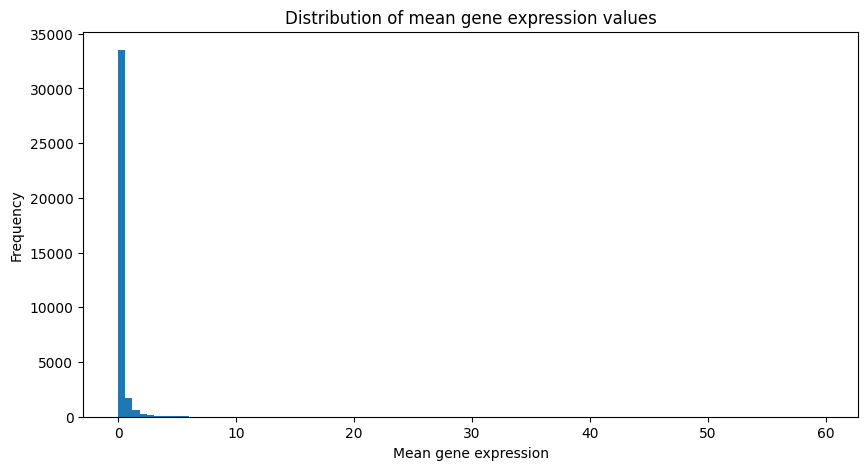

In [29]:
# plot mean of gene expression values across samples
plt.figure(figsize=(10, 5))
plt.hist(gex_df.mean(axis=0), bins=100)
plt.xlabel("Mean gene expression")
plt.ylabel("Frequency")
plt.title("Distribution of mean gene expression values")